In [72]:
import importlib

In [73]:
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep, Hitter_IO
import Prep_Map
importlib.reload(Prep_Map)
import Output_Map
importlib.reload(Output_Map)

data_prep = Data_Prep(Prep_Map.base_prep_map, Output_Map.war_map)

In [74]:
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1))

In [75]:
from sklearn.model_selection import train_test_split # type: ignore
import torch
io_train : list[Hitter_IO]
io_test : list[Hitter_IO]
io_train, io_test = train_test_split(hitter_io_list, test_size=0.25, random_state=0)

train_lengths = torch.tensor([io.length for io in io_train])
test_lengths = torch.tensor([io.length for io in io_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence([io.input for io in io_train])
x_test_padded = torch.nn.utils.rnn.pad_sequence([io.input for io in io_test])
y_prospect_train_padded = torch.nn.utils.rnn.pad_sequence([io.output for io in io_train])
y_prospect_test_padded = torch.nn.utils.rnn.pad_sequence([io.output for io in io_test])
y_stats_train_padded = torch.nn.utils.rnn.pad_sequence([io.stat_output for io in io_train])
y_stats_test_padded = torch.nn.utils.rnn.pad_sequence([io.stat_output for io in io_test])
y_position_train_padded = torch.nn.utils.rnn.pad_sequence([io.position_output for io in io_train])
y_position_test_padded = torch.nn.utils.rnn.pad_sequence([io.position_output for io in io_test])
mask_prospect_train_padded = torch.nn.utils.rnn.pad_sequence([io.prospect_mask for io in io_train])
mask_prospect_test_padded = torch.nn.utils.rnn.pad_sequence([io.prospect_mask for io in io_test])
mask_level_train_padded = torch.nn.utils.rnn.pad_sequence([io.stat_level_mask for io in io_train])
mask_level_test_padded = torch.nn.utils.rnn.pad_sequence([io.stat_level_mask for io in io_test])

In [76]:
import Hitter_Dataset
importlib.reload(Hitter_Dataset)
from Hitter_Dataset import Hitter_Dataset

train_hitters_dataset = Hitter_Dataset(x_train_padded, train_lengths, y_prospect_train_padded, y_stats_train_padded, y_position_train_padded, mask_prospect_train_padded, mask_level_train_padded)
test_hitters_dataset = Hitter_Dataset(x_test_padded, test_lengths, y_prospect_test_padded, y_stats_test_padded, y_position_test_padded, mask_prospect_test_padded, mask_level_test_padded)

Train Model

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 18046
Epoch [1/1000], Train Loss: 21.3548, Test Loss: 6.4965
Epoch [2/1000], Train Loss: 6.5658, Test Loss: 6.2266
Epoch [3/1000], Train Loss: 6.2776, Test Loss: 6.1178
Epoch [4/1000], Train Loss: 6.2244, Test Loss: 6.0835
Epoch [5/1000], Train Loss: 6.1849, Test Loss: 6.0525
Epoch [6/1000], Train Loss: 6.1681, Test Loss: 6.0345
Epoch [7/1000], Train Loss: 6.1623, Test Loss: 6.0229
Epoch [8/1000], Train Loss: 6.1561, Test Loss: 6.0236
Epoch [9/1000], Train Loss: 6.1512, Test Loss: 6.0233
Epoch [10/1000], Train Loss: 6.1620, Test Loss: 6.0392
Epoch [11/1000], Train Loss: 6.1630, Test Loss: 6.0281
Epoch [12/1000], Train Loss: 6.1488, Test Loss: 6.0115
Epoch [13/1000], Train Loss: 6.1468, Test Loss: 6.0168
Epoch [14/1000], Train Loss: 6.1561, Test Loss: 6.0339
Epoch [15/1000], Train Loss: 6.1579, Test Loss: 6.0401
Epoch [16/1000], Train Loss: 6.1482, Test Loss: 6.0205
Epoch [17/1000], Train Loss: 6.1539, Test Loss: 6.0247
Epoch [18/1000], Train Loss: 6.1649, Test Loss: 6.

4.288271175365696

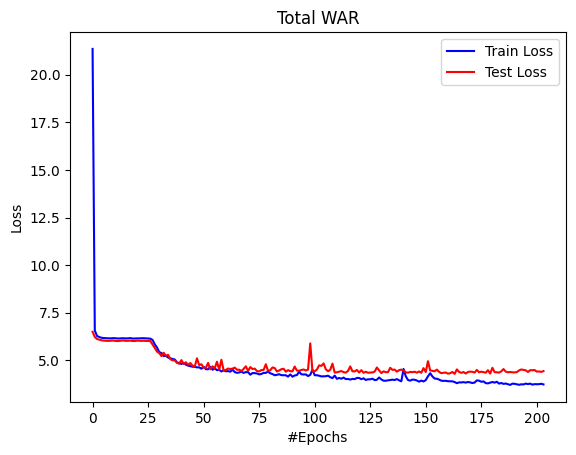

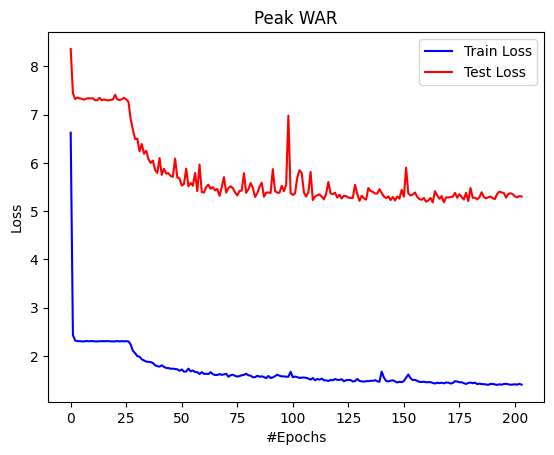

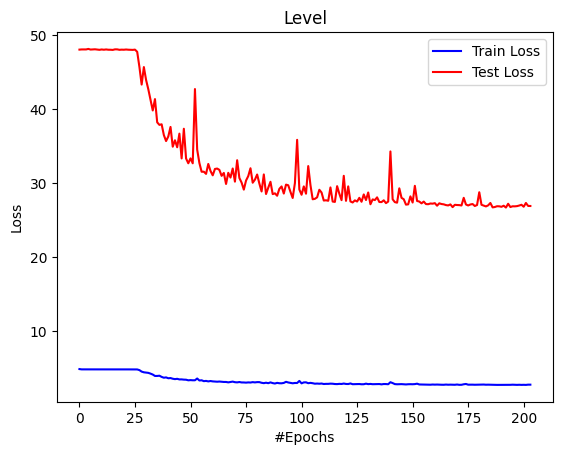

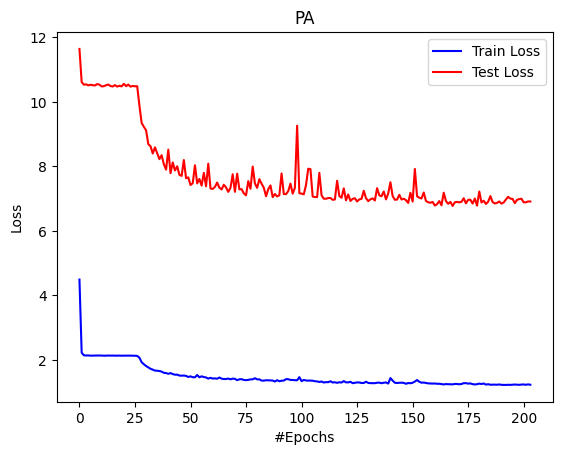

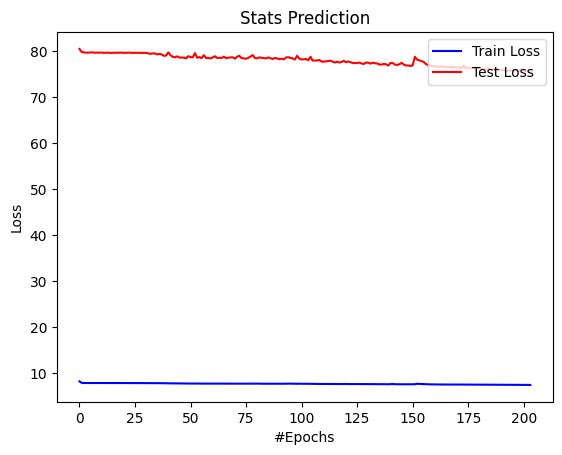

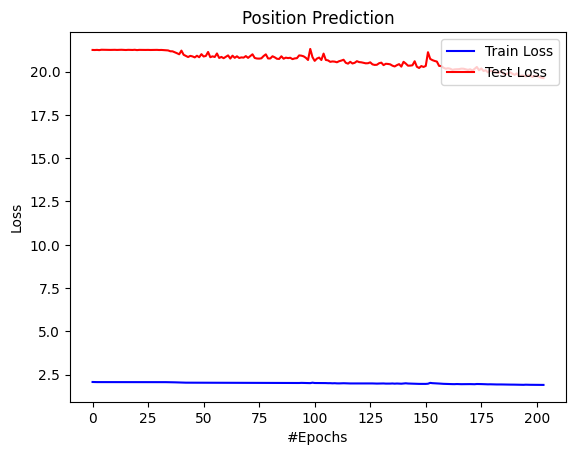

In [ ]:
import Hitter_Model
importlib.reload(Hitter_Model)
from Hitter_Model import RNN_Model, Classification_Loss, Stats_L1_Loss
from torch.optim import lr_scheduler
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph
from Constants import device

batch_size = 200
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Hitter_IO.GetMaxLength(hitter_io_list))

num_layers = 3
hidden_size = 25
network = RNN_Model(x_train_padded[0].shape[1], num_layers, hidden_size, hitting_mutators, output_map=data_prep.output_map)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = Classification_Loss
loss_function_stats = Stats_L1_Loss
loss_function_position = Hitter_Model.Position_Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_hitters_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_hitters_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.1,0.5)
trainAndGraph(network, training_generator, testing_generator, len(train_hitters_dataset), len(test_hitters_dataset), loss_function, loss_function_stats, loss_function_position, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=40, should_output=True)

Testing

In [79]:
import torch.nn as nn
import sqlite3
from tqdm import tqdm
test_db = sqlite3.connect('test.db')

In [80]:
network.load_state_dict(torch.load("no_name.pt"))
network.eval()
network = network.to(device)

In [81]:
cursor = test_db.cursor()
cursor.execute("DELETE FROM StatPred")
cursor.execute("DELETE FROM StatAct")
test_db.commit()
cursor = test_db

softmax = nn.Softmax(dim=0)

for io in tqdm(hitter_io_list):
    hitter = io.hitter
    input = io.input.unsqueeze(0)  
    output = io.output
    l = torch.tensor([input.shape[1]])
    twar, pwar, level, pa, stats, positions = network(input.to(device), l.to(device))
    
    for i in range(io.stat_output.size(0)):
        position_probs = softmax(positions.squeeze(0)[i,:9])
        test_db.execute("INSERT INTO StatPred VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(stats.squeeze(0)[i,:11].tolist()) + tuple(position_probs.tolist()))
        test_db.execute("INSERT INTO StatAct VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(io.stat_output[i,:].tolist()) + tuple(io.position_output[i,:].tolist()))
test_db.commit()

100%|██████████| 8916/8916 [01:31<00:00, 97.38it/s] 


In [82]:
import torch.nn.functional as F

def Check_Hitter(id : int, name : str):
    with torch.no_grad():
        for io in hitter_io_list:
            hitter = io.hitter
            if (hitter.mlbId == id):
                input = io.input.unsqueeze(0)
                
                output = io.output
                l = torch.tensor([input.shape[1]])
                twar, pwar, level, pa, stats, positions = network(input.to(device), l.to(device))
                
                torch.set_printoptions(precision=3, sci_mode=False, linewidth=1000, threshold=500000)
                print(name)
                twar = twar.squeeze(0)[:io.prospect_mask.count_nonzero()]
                print(F.softmax(twar.squeeze(1), dim=1).cpu())
                #print(F.softmax(level.squeeze(0).squeeze(1), dim=1).cpu())
                print(output[0][0].item())
                #print(output[0][2].item())
                return

Get Hitter Losses

In [83]:
#Check_Hitter(596146, "Max Kepler")
Check_Hitter(545361, "Mike Trout")
#Check_Hitter(518769, "Michael Harrington")
#Check_Hitter(542454, "Danny Santana")
#Check_Hitter(605381, "Levi Michael")

Mike Trout
tensor([[0.713, 0.050, 0.042, 0.056, 0.075, 0.044, 0.019],
        [0.762, 0.041, 0.028, 0.072, 0.065, 0.027, 0.004],
        [0.779, 0.033, 0.024, 0.065, 0.069, 0.026, 0.004],
        [0.835, 0.034, 0.023, 0.048, 0.045, 0.013, 0.002],
        [0.651, 0.045, 0.051, 0.095, 0.112, 0.039, 0.008],
        [0.336, 0.037, 0.089, 0.148, 0.250, 0.105, 0.034],
        [0.294, 0.037, 0.112, 0.156, 0.266, 0.102, 0.033],
        [0.299, 0.039, 0.113, 0.161, 0.269, 0.092, 0.028],
        [0.260, 0.040, 0.120, 0.171, 0.282, 0.097, 0.030],
        [0.158, 0.043, 0.147, 0.192, 0.295, 0.117, 0.047],
        [0.068, 0.054, 0.119, 0.213, 0.364, 0.126, 0.056],
        [0.027, 0.047, 0.078, 0.188, 0.443, 0.144, 0.074],
        [0.021, 0.042, 0.067, 0.178, 0.466, 0.151, 0.076],
        [0.023, 0.047, 0.072, 0.184, 0.448, 0.149, 0.076],
        [0.021, 0.044, 0.069, 0.182, 0.462, 0.148, 0.074],
        [0.024, 0.048, 0.073, 0.185, 0.445, 0.149, 0.076]])
6
